In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
import sys
import gym
import torch
import pandas as pd

sys.path.append('../modules/')
from Agents.RepresentationLearning import PlaceCells
from Utils.gridworld_plotting import *
from Utils import one_hot_state
sys.path.append('../../')## add basic so torch can load agent


# make policy and value arrays
def snapshot(sample_states, observations):
    # initialize empty data frames
    pol_grid = np.zeros(env.shape, dtype=[(x, 'f8') for x in env.action_list])
    val_grid = np.empty(env.shape)

    mem_grid = np.zeros(env.shape, dtype=[(x, 'f8') for x in env.action_list])

    # forward pass through network
    pols, vals = network(observations)

    # populate with data from network
    for s, p, v in zip(sample_states, pols, vals):
        pol_grid[s] = tuple(p.data.numpy())
        val_grid[s] = v.item()

    
    return pol_grid, val_grid

In [ ]:
df = pd.read_csv('../Data/mf_training.csv')

In [ ]:
agent_id = '43027cdd-8361-44a5-9cf7-c8463addb11a'

# get row of data frame with details of run
details = df.loc[df['run_id']==agent_id]

# reconstruct env
env_id = details['env_type'].values[0]
env = gym.make(env_id)
plt.show()

# reconstruct agent  
network = torch.load(f'../Data/agents/{agent_id}.pt')
with open(f'../Data/results/{agent_id}_data.p', 'rb') as f:
    data = pickle.load(f)
    
state_reps = {}
if 'place_cells' in data.keys():
    print('using PC rep')
    num_cells = details['Num_inputs'].values[0]
    place_cell_field_size = details['PlaceCell_fieldsize'].values[0]
    print(f'Field Size is {place_cell_field_size}')
    place_cell_centres = data['place_cells']
    place_cells = PlaceCells(env.shape, num_cells=int(num_cells), cell_centres =place_cell_centres, field_size=place_cell_field_size)
    for state in env.useable:
        state_reps[env.twoD2oneD(state)] = place_cells.get_activities([state])
else:
    for state in env.useable:
        state_reps[env.twoD2oneD(state)]= one_hot_state(env, env.twoD2oneD(state))

In [ ]:
sample_states = [env.oneD2twoD(s) for s in list(state_reps.keys())]
if 'place_cells' in data.keys():
    observations = [rep[0] for rep in list(state_reps.values())]
else:
    observations = list(state_reps.values())
p, v = snapshot(sample_states, observations)

p,v = data['P_snap'][-1], data['V_snap'][-1]

In [ ]:
plot_polmap(env,p)
plot_pref_pol(env,p)
plot_valmap(env,v, v_range=[0,10])

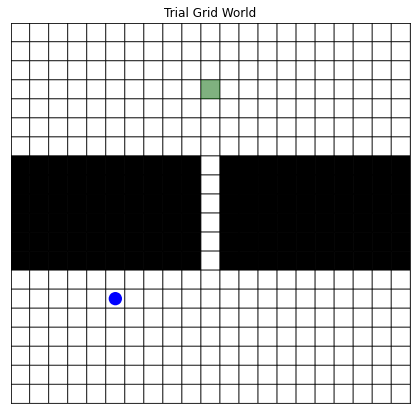

In [113]:
# load in sr matrix
env_id = 'gridworld:gridworld-v5'
env = gym.make(env_id)
plt.close()

In [47]:
# get SR
with open(f'../modules/Agents/RepresentationLearning/SR_{env_id[10:]}.p', 'rb') as f:
    sr_ = pickle.load(f)
SR_ = np.sum(sr_, axis = 0) ## sum over all actions

# get place cell
cell_centres = np.zeros((env.nstates,2))
for i in range(env.nstates):
    cell_centres[i] = np.multiply(env.oneD2twoD(i), (1/env.shape[0], 1/env.shape[1]))
# get place cells
pcs_ = PlaceCells(env.shape, num_cells=env.nstates, cell_centres=cell_centres, field_size=1/env.shape[0])



SR_reps = {}
SR = np.zeros((env.nstates, env.nstates))
#SR[:] = np.nan
for state in env.useable:
    index = env.twoD2oneD(state)
    SR_reps[index] = SR_[index]
    SR[index] = SR_[index]/np.sqrt(np.nansum(np.square(SR_[index])))


pc_reps = {}
PC = np.zeros((env.nstates, env.nstates))
#PC[:] = np.nan
for state in env.useable:
    i = env.twoD2oneD(state)
    pc_reps[i] = pcs_.get_activities([state])
    PC[i] = pc_reps[i]/np.linalg.norm(pc_reps[i])

<ipython-input-47-b995c8b495e7>:21: RuntimeWarning: invalid value encountered in true_divide
  SR[index] = SR_[index]/np.sqrt(np.nansum(np.square(SR_[index])))


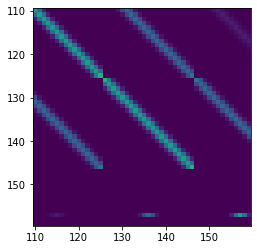

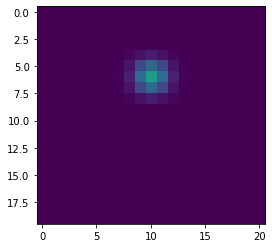

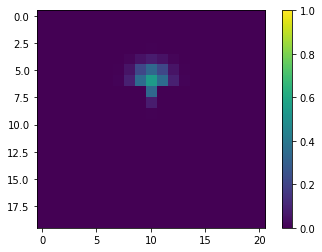

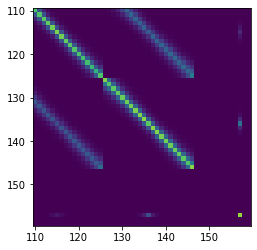

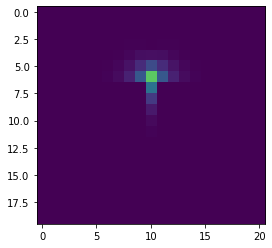

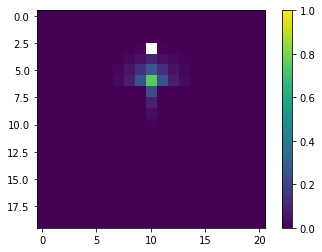

In [61]:
start, scale = 110, 50
index = 136

vmin, vmax= 0,1
## PLACE CELLS 
#activity matrix
plt.figure()
plt.imshow(PC[start:start+scale,start:start+scale], vmin=vmin, vmax=vmax)
plt.yticks(np.arange(0,scale,10), labels=np.arange(start,start+scale,10))
plt.xticks(np.arange(0,scale,10), labels=np.arange(start,start+scale,10))

# row activity - state activity
plt.figure()
plt.imshow(PC[index].reshape(*env.shape), vmin=vmin, vmax=vmax)
# column activity - place field
plt.figure()
ax1 = plt.imshow(PC[:,index].reshape(*env.shape), vmin=vmin, vmax=vmax)
plt.colorbar(ax1)


## SUCCESSOR REPRESENTATION
# activity matrix
plt.figure()
plt.imshow(SR[start:start+scale,start:start+scale], vmin=vmin, vmax=vmax)
plt.yticks(np.arange(0,scale,10), labels=np.arange(start,start+scale,10))
plt.xticks(np.arange(0,scale,10), labels=np.arange(start,start+scale,10))

# row activity
plt.figure()
plt.imshow(SR[index].reshape(*env.shape), vmin=vmin, vmax=vmax)
# column activity
plt.figure()
ax2 = plt.imshow(SR[:,index].reshape(*env.shape), vmin=vmin, vmax=vmax)
plt.colorbar(ax2)

plt.show()
plt.close()


(420, 420)


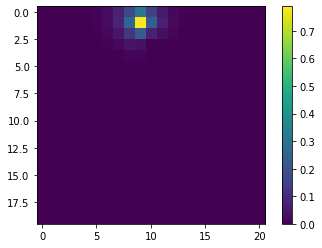

In [95]:
I = np.eye(SR.shape[0])
ksteps = 1

state = 30

transform = np.matmul(np.nan_to_num(SR)**ksteps, I)
print(transform.shape)
plt.figure()
ax = plt.imshow(transform[state].reshape(*env.shape))
plt.colorbar(ax)
plt.show()

In [107]:
print(env.P.shape)
adj = np.sum(env.P, axis=0)

(4, 400, 400)


(-3.9553233049005034+0j)


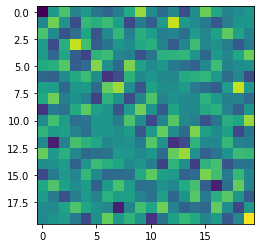

In [112]:
w, v = np.linalg.eig(adj)
print(w[0])
plt.figure()
plt.imshow(v[:,-10].real.reshape(*env.shape))
plt.show()

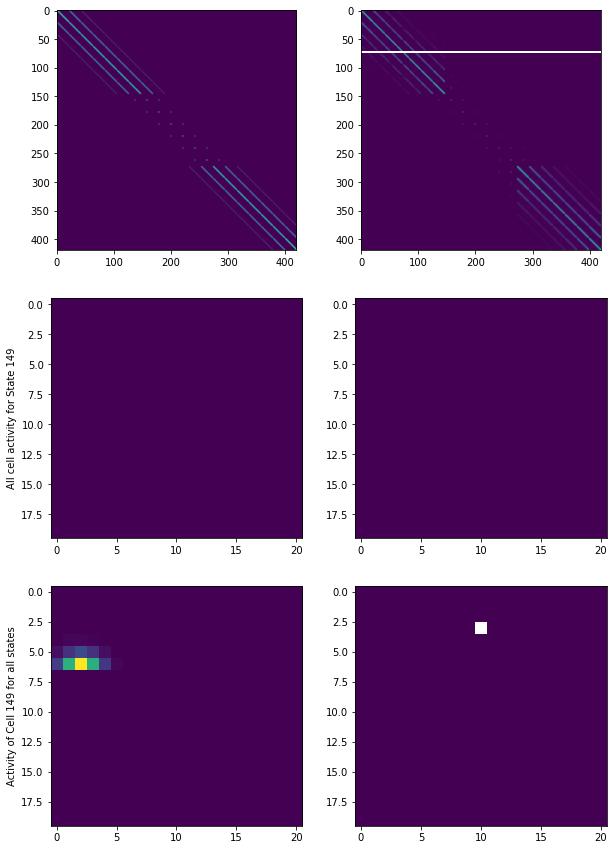